In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import requests
import time
import typing as tp
import os
from dotenv import load_dotenv
import pickle
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import optuna
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


/home/kirill/miniconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [250]:
DATA_PATH = 'data'
ARTIFACTS_PATH = 'artifacts'
MODELS_PATH = 'models'
SEED = 42

In [214]:
data = pd.read_csv(os.path.join(DATA_PATH, 'x_train.csv'))
features = pd.read_excel(os.path.join(DATA_PATH, 'Kazan_minzhkh.xlsx'))
train_data = pd.merge(data, features, on='Короткий Адрес', how='left')
train_data = train_data.drop_duplicates(subset='uuid')

In [215]:
load_dotenv()

True

## EDA

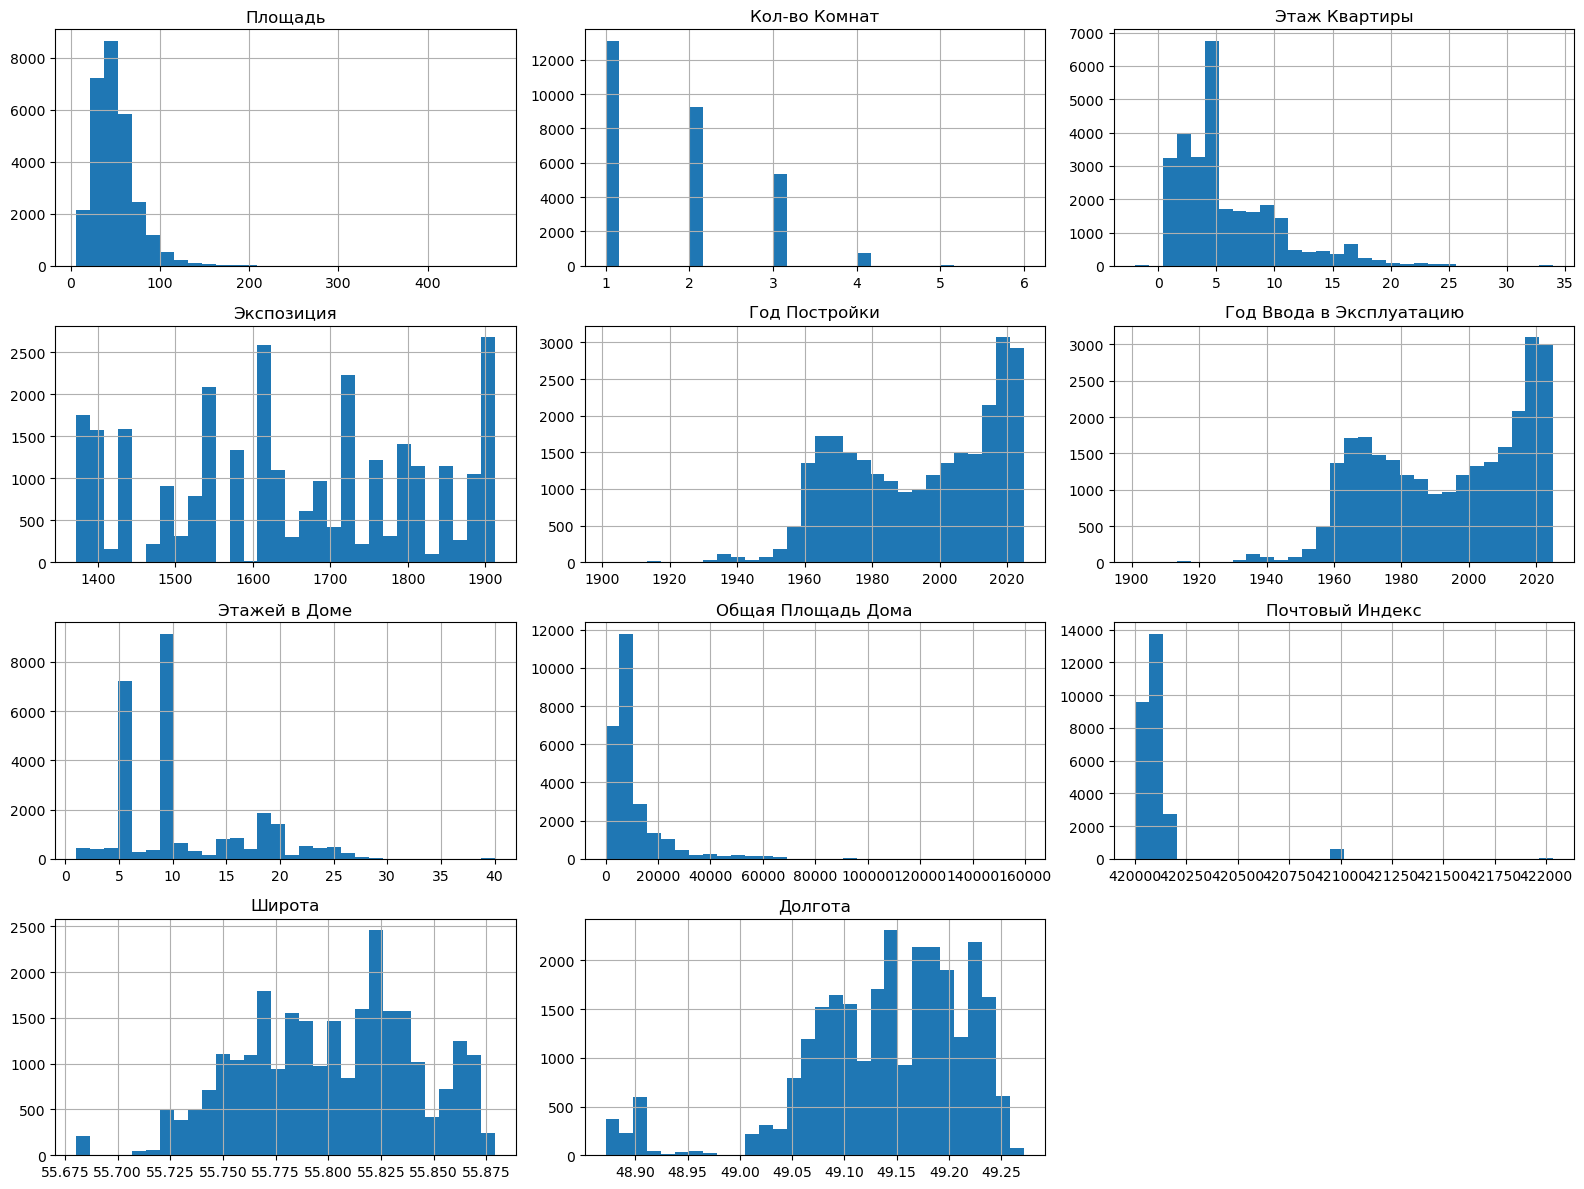

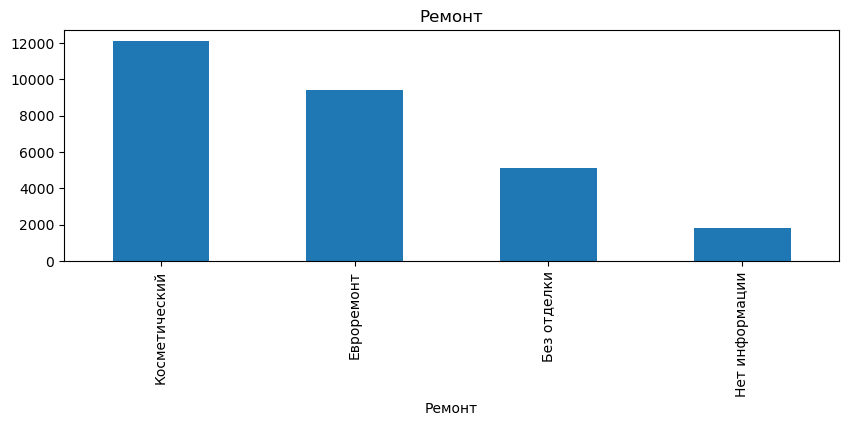

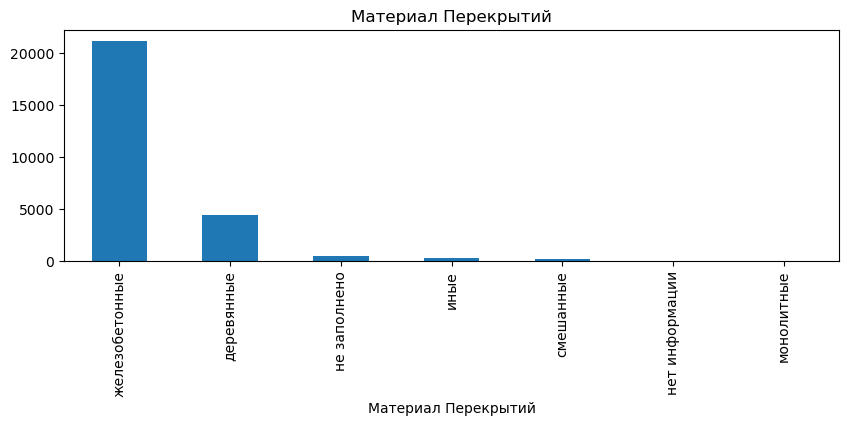

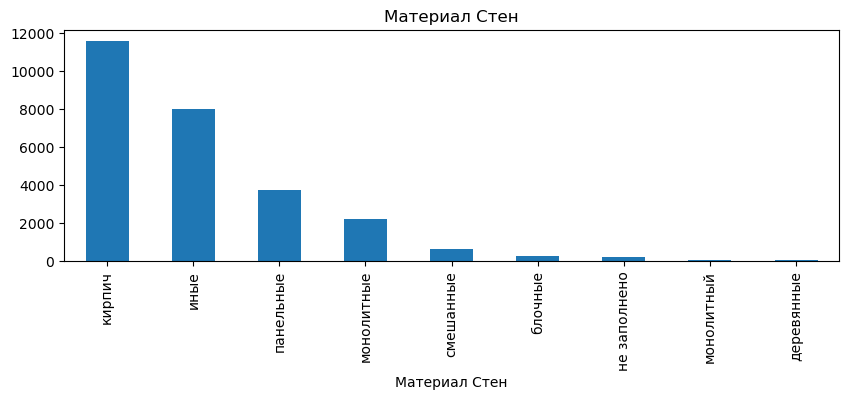

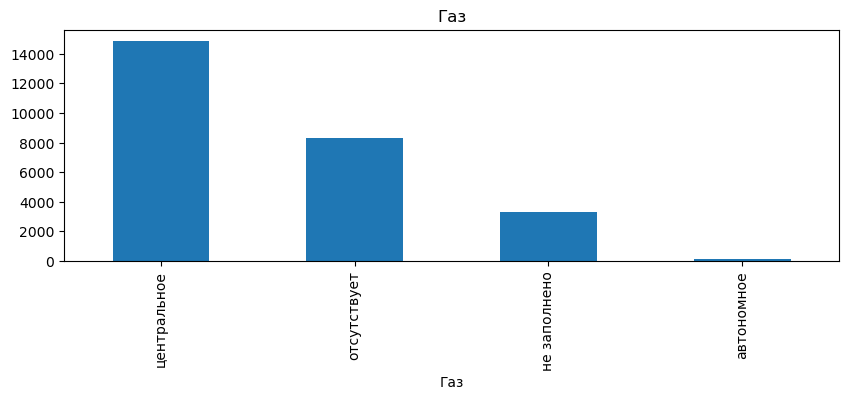

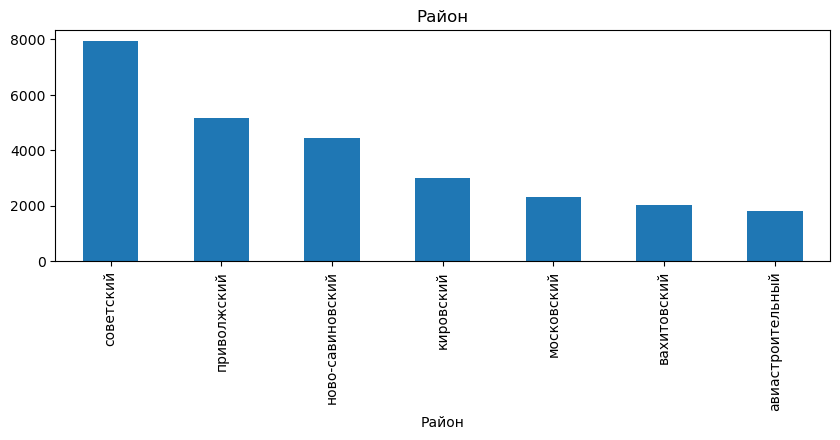

In [216]:
import matplotlib.pyplot as plt

numeric_columns = train_data.select_dtypes(include=[np.number]).columns
train_data[numeric_columns].hist(figsize=(16, 12), bins=30)
plt.tight_layout()
plt.show()


categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns
categorical_columns = [
    col for col in categorical_columns if col != 'uuid' and col != 'Короткий Адрес'
]
for col in categorical_columns:
    plt.figure(figsize=(10, 3))
    train_data[col].value_counts().plot(kind='bar')
    plt.title(f'{col}')
    plt.show()

In [217]:
train_data.isna().sum()

uuid                           0
Короткий Адрес                 0
Площадь                        0
Кол-во Комнат                  0
Этаж Квартиры                  0
Ремонт                         0
Экспозиция                     0
Год Постройки               1846
Год Ввода в Эксплуатацию    1846
Этажей в Доме               1846
Общая Площадь Дома          2789
Материал Перекрытий         1846
Материал Стен               1846
Газ                         1846
Район                       1846
Почтовый Индекс             1846
Широта                      1846
Долгота                     1846
dtype: int64

## Fill NA

### 1. Parsing and pseudo labeling for district column

For filling missing values in District column we used coordinates parsing from YandexMaps API, then predicted District value using KNN

In [273]:
def get_lat_long_yandex(address: str, api_key: str) -> tp.Optional[tp.Tuple[float, float]]:
    base_url = "https://geocode-maps.yandex.ru/v1/"
    params = {
        "geocode": address,
        "apikey": api_key,
        "format": "json"
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        try:
            pos = response.json()['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos']
            lng, lat = map(float, pos.split())
            return lat, lng
        except (IndexError, KeyError):
            return None, None
    return None, None

In [ ]:
'''UNCOMMENT IF YOU WANT TO GET COORDS FROM API'''

# yandex_api_key = os.getenv("YANDEX_API_KEY")
# addresses = train_data.loc[train_data['Широта'].isna(), 'Короткий Адрес'].unique()


# coords = []
# for addr in tqdm(list(addresses)):
#     lat, lng = get_lat_long_yandex(addr + ", Казань, Россия", yandex_api_key)
#     coords.append({'Короткий Адрес': addr, 'Широта': lat, 'Долгота': lng})
#     time.sleep(0.1)

# coords_df = pd.DataFrame(coords)
# coords_df.to_csv(os.path.join(ARTIFACTS_PATH, 'lat_long_train.csv'), index=False)
# coords_df.head()

In [219]:
coords_df_train = pd.read_csv(os.path.join(ARTIFACTS_PATH, 'lat_long_train.csv'))

In [220]:
train_data = pd.merge(train_data, coords_df_train, on='Короткий Адрес', how='left', suffixes=('', '_new'))
train_data['Широта'] = train_data['Широта'].combine_first(train_data['Широта_new'])
train_data['Долгота'] = train_data['Долгота'].combine_first(train_data['Долгота_new'])
train_data = train_data.drop(columns=['Широта_new', 'Долгота_new'])

In [ ]:
X_knn = train_data.loc[train_data['Район'].notna(), ['Широта', 'Долгота']]
y_knn = train_data.loc[train_data['Район'].notna(), 'Район']

X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(X_knn, y_knn, test_size=0.2, random_state=42)


knn_district = KNeighborsClassifier(n_neighbors=5)
knn_district.fit(X_train_knn, y_train_knn)


y_pred = knn_district.predict(X_val_knn)
print("Acc", accuracy_score(y_val_knn, y_pred))
print("Precision", precision_score(y_val_knn, y_pred, average='macro'))
print("Recall", recall_score(y_val_knn, y_pred, average='macro'))
print("f1", f1_score(y_val_knn, y_pred, average='macro'))

print(classification_report(y_val_knn, y_pred))

Acc 0.998874296435272
Precision 0.998588572611434
Recall 0.9985872725236069
f1 0.9985873339968165
                  precision    recall  f1-score   support

авиастроительный       1.00      1.00      1.00       379
     вахитовский       1.00      1.00      1.00       374
       кировский       1.00      1.00      1.00       618
      московский       1.00      1.00      1.00       446
ново-савиновский       1.00      1.00      1.00       895
     приволжский       1.00      1.00      1.00      1004
       советский       1.00      1.00      1.00      1614

        accuracy                           1.00      5330
       macro avg       1.00      1.00      1.00      5330
    weighted avg       1.00      1.00      1.00      5330



In [222]:
knn_district = KNeighborsClassifier(n_neighbors=5)
knn_district.fit(X_knn, y_knn)


X_pred = train_data.loc[train_data['Район'].isna(), ['Широта', 'Долгота']]
district_pred = knn_district.predict(X_pred)

train_data.loc[train_data['Район'].isna(), 'Район'] = district_pred
print(train_data['Район'].isna().value_counts())

Район
False    28496
Name: count, dtype: int64


In [223]:
train_data = train_data.drop(columns=['Короткий Адрес'])

### Fill with mean and mode

This approach is not semantically correct, but due to low feature importance of filled features this approach worked. In terms of hackathon this filling solution was made due to lack of time. For proper filling further research is needed

In [ ]:
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns
categorical_columns = [col for col in categorical_columns if col != 'uuid']

for col in numeric_columns:
    train_data[col] = train_data[col].fillna(train_data[col].median())

for col in categorical_columns:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])

le = [LabelEncoder() for i in range(len(categorical_columns))]

for i, col in enumerate(categorical_columns):
    train_data[col] = le[i].fit_transform(train_data[col].astype(str))

with open(os.path.join(ARTIFACTS_PATH, 'label_encoders.pkl'), 'wb') as f:
    pickle.dump(le, f)



In [225]:
train_data.isna().sum()

uuid                        0
Площадь                     0
Кол-во Комнат               0
Этаж Квартиры               0
Ремонт                      0
Экспозиция                  0
Год Постройки               0
Год Ввода в Эксплуатацию    0
Этажей в Доме               0
Общая Площадь Дома          0
Материал Перекрытий         0
Материал Стен               0
Газ                         0
Район                       0
Почтовый Индекс             0
Широта                      0
Долгота                     0
dtype: int64

In [226]:
labels = pd.read_csv(os.path.join(DATA_PATH, 'y_train.csv'))
train_data = pd.merge(train_data, labels, on='uuid')
train_data

,uuid,Площадь,Кол-во Комнат,Этаж Квартиры,Ремонт,Экспозиция,Год Постройки,Год Ввода в Эксплуатацию,Этажей в Доме,Общая Площадь Дома,Материал Перекрытий,Материал Стен,Газ,Район,Почтовый Индекс,Широта,Долгота,Цена за квадрат
0,a5d5fd1d-b94c-4d55-b317-b586c1a9bbfb,69,2,5,0,1608,2015.0,2015.0,11.0,43698.700000,0,2,3,5,420049.0,55.768583,49.152417,214536
1,7cf1c0cd-e61c-484c-ae32-3a9fb9c625af,31,1,3,1,1818,2021.0,2021.0,20.0,13184.700000,1,4,2,6,420125.0,55.787748,49.254719,205502
2,50e9fc67-7151-4cd2-b3c8-6c47f1936cb1,65,2,20,0,1731,2019.0,2019.0,27.0,6215.795935,1,3,2,6,420087.0,55.766932,49.171425,221183
3,6cc0bc58-889e-4a7f-936b-7dddfea17a6d,42,2,19,1,1883,2019.0,2019.0,20.0,6215.795935,1,3,2,5,420064.0,55.729995,49.171569,216627
4,f56db2b1-5b8d-4601-b388-a0723e40c3bb,45,1,3,2,1608,2008.0,2008.0,9.0,10330.000000,1,3,3,4,420126.0,55.816485,49.138681,212054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28491,09a138fa-ce25-406f-8ff9-64bfdcd4f88a,59,2,11,2,1578,2013.0,2013.0,18.0,10013.000000,1,2,2,3,420034.0,55.819353,49.087999,176223
28492,5335d192-b542-43e3-8dac-6414a37b7f9b,34,1,8,2,1608,1996.0,1996.0,9.0,11460.640000,0,2,3,6,420100.0,55.776477,49.230031,179104
28493,f980d3e5-d7c0-4d42-8fa1-07fa718dd19a,54,1,4,1,1534,2013.0,2013.0,21.0,22591.260000,1,3,2,4,421001.0,55.820051,49.144817,176394
28494,d625fa73-90f7-4c4a-8bc8-456c1a480d3a,83,2,5,1,1911,2002.0,2002.0,5.0,4131.300000,1,3,3,3,420039.0,55.839582,49.065783,178960


In [227]:
train_data.to_csv(os.path.join(ARTIFACTS_PATH, 'train_data_encoded.csv'), index=False)

## Train val split

Kaggle closed tests disribution matches with train data distribution, so evaluation on val sample represents true score

In [228]:
from sklearn.model_selection import train_test_split



train, val = train_test_split(train_data, train_size=0.9, random_state=SEED)
X_all, y_all = train_data.drop(columns=['uuid', 'Цена за квадрат']), train['Цена за квадрат']
X_train, y_train = train.drop(columns=['uuid', 'Цена за квадрат']), train['Цена за квадрат']
X_val, y_val = val.drop(columns=['uuid', 'Цена за квадрат']), val['Цена за квадрат']

X_all


,Площадь,Кол-во Комнат,Этаж Квартиры,Ремонт,Экспозиция,Год Постройки,Год Ввода в Эксплуатацию,Этажей в Доме,Общая Площадь Дома,Материал Перекрытий,Материал Стен,Газ,Район,Почтовый Индекс,Широта,Долгота
0,69,2,5,0,1608,2015.0,2015.0,11.0,43698.700000,0,2,3,5,420049.0,55.768583,49.152417
1,31,1,3,1,1818,2021.0,2021.0,20.0,13184.700000,1,4,2,6,420125.0,55.787748,49.254719
2,65,2,20,0,1731,2019.0,2019.0,27.0,6215.795935,1,3,2,6,420087.0,55.766932,49.171425
3,42,2,19,1,1883,2019.0,2019.0,20.0,6215.795935,1,3,2,5,420064.0,55.729995,49.171569
4,45,1,3,2,1608,2008.0,2008.0,9.0,10330.000000,1,3,3,4,420126.0,55.816485,49.138681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28491,59,2,11,2,1578,2013.0,2013.0,18.0,10013.000000,1,2,2,3,420034.0,55.819353,49.087999
28492,34,1,8,2,1608,1996.0,1996.0,9.0,11460.640000,0,2,3,6,420100.0,55.776477,49.230031
28493,54,1,4,1,1534,2013.0,2013.0,21.0,22591.260000,1,3,2,4,421001.0,55.820051,49.144817
28494,83,2,5,1,1911,2002.0,2002.0,5.0,4131.300000,1,3,3,3,420039.0,55.839582,49.065783


## Models baseline

In [233]:
model = XGBRegressor(random_state=SEED)
model.fit(X_train, y_train)


y_pred = model.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print('XGBoost baseline')
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.4f}")

XGBoost baseline
RMSE: 22922.17
MAE: 15346.37
R2: 0.8103


In [232]:
model_cb = CatBoostRegressor(verbose=False)
model_cb.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

preds_cb = model_cb.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, preds_cb))
mae = mean_absolute_error(y_val, preds_cb)
r2 = r2_score(y_val, preds_cb)

print('Catboost baseline')
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.4f}")

Catboost baseline
RMSE: 22503.12
MAE: 15018.06
R2: 0.8172


## Hyperparameter tuning

In [234]:
N_TRIALS = 50
progress_bar = tqdm(total=N_TRIALS)

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 300, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 12),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 100, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-2, 10, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "verbose": 0,
        "random_seed": SEED
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)

    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))

    progress_bar.update(1)
    return rmse


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=N_TRIALS)

progress_bar.close()

print("Best params:", study.best_params)
print("Best RMSE:", study.best_value)


100%|██████████| 50/50 [08:17<00:00,  9.95s/it]

Best params: {'iterations': 1866, 'learning_rate': 0.04177826543083045, 'depth': 10, 'l2_leaf_reg': 0.02551132775857687, 'random_strength': 3.329258539529853, 'border_count': 134, 'grow_policy': 'Depthwise', 'bootstrap_type': 'MVS'}
Best RMSE: 20234.135615510837


In [ ]:
with open(os.path.join(ARTIFACTS_PATH, 'best_params.pkl'), 'wb') as f:
    pickle.dump(study.best_params, f)

In [248]:
with open(os.path.join(ARTIFACTS_PATH, 'best_params.pkl'), 'rb') as f:
    best_params = pickle.load(f)

best_params["verbose"] = 0
best_params["random_seed"] = SEED

model_best = CatBoostRegressor(**best_params)
model_best.fit(X_train, y_train, cat_features=[])

y_pred_best = model_best.predict(X_val)

rmse = np.sqrt(mean_squared_error(y_val, y_pred_best))
mae = mean_absolute_error(y_val, y_pred_best)
r2 = r2_score(y_val, y_pred_best)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.4f}")

RMSE: 20518.90
MAE: 13563.00
R2: 0.8480


### Random seed tuning

In [ ]:
NUM_SEEDS = 50
seed_results = []

for seed in tqdm(range(1, NUM_SEEDS + 1), desc="Seed tuning"):
    best_params_seeded = best_params.copy()
    best_params_seeded["random_seed"] = seed

    model = CatBoostRegressor(**best_params_seeded)
    model.fit(X_train, y_train, cat_features=[], verbose=0)
    preds = model.predict(X_val)

    rmse = np.sqrt(mean_squared_error(y_val, preds))
    seed_results.append({"seed": seed, "rmse": rmse})


seed_df = pd.DataFrame(seed_results)
seed_df.to_csv(os.path.join(ARTIFACTS_PATH, "catboost_seed_tuning_results.csv"), index=False)

print("\nTop 10 seeds with lowest RMSE:")
print(seed_df.sort_values("rmse").head(10))

print(f"\nMean RMSE across seeds: {seed_df['rmse'].mean():.4f}")
print(f"Std deviation of RMSE: {seed_df['rmse'].std():.4f}")


Seed tuning: 100%|██████████| 50/50 [06:27<00:00,  7.76s/it]


Top 10 seeds with lowest RMSE:
    seed          rmse
18    19  20310.141939
31    32  20318.132394
34    35  20341.278113
12    13  20341.907249
16    17  20353.231034
47    48  20363.294291
27    28  20366.319903
8      9  20382.058245
35    36  20385.635335
3      4  20396.776787

Mean RMSE across seeds: 20520.3793
Std deviation of RMSE: 113.3682


In [ ]:
model_best.save_model(os.path.join(MODELS_PATH, "catboost_model_BEST.cbm"))

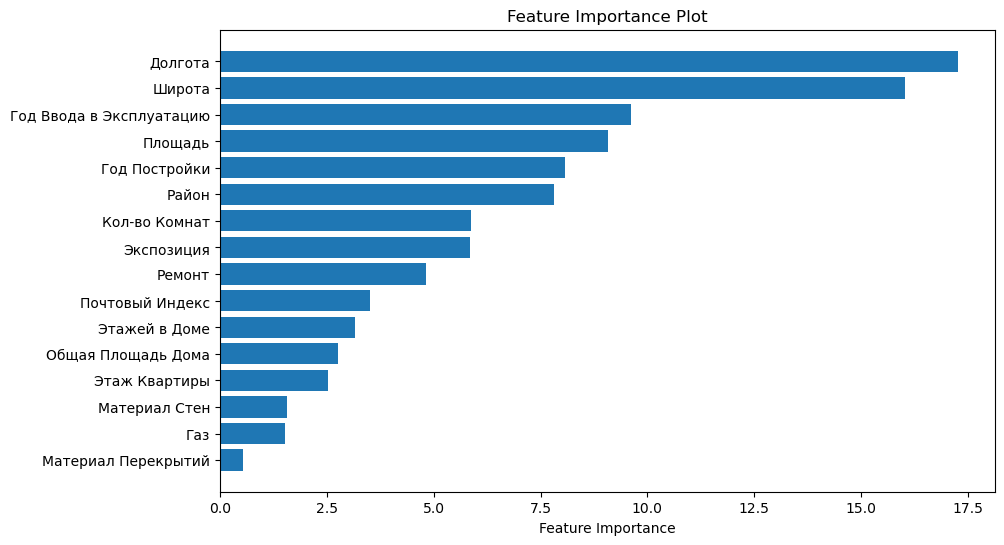

In [252]:
plt.figure(figsize=(10, 6))
feature_importances = model.feature_importances_
sorted_idx = feature_importances.argsort()
plt.barh(X_train.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance Plot")
plt.show()

# Inference

In [275]:
test_data = pd.read_csv(os.path.join(DATA_PATH, 'x_test.csv'))
test_features = pd.read_excel(os.path.join(DATA_PATH, 'Kazan_minzhkh.xlsx'))
test_data = pd.merge(test_data, features, on='Короткий Адрес', how='left')

In [276]:
'''UNCOMMENT IF YOU WANT TO GET COORDS FROM API'''

# addresses = test_data.loc[test_data['Широта'].isna(), 'Короткий Адрес'].unique()

# coords = []
# for addr in tqdm(list(addresses)):
#     lat, lng = get_lat_long_yandex(addr + ", Казань, Россия", yandex_api_key)
#     coords.append({'Короткий Адрес': addr, 'Широта': lat, 'Долгота': lng})
#     time.sleep(0.1)

# coords_df_test = pd.DataFrame(coords)
# coords_df_test.to_csv(os.path.join(ARTIFACTS_PATH, 'lat_long_test.csv'), index=False)
# coords_df_test.head()

'UNCOMMENT IF YOU WANT TO GET COORDS FROM API'

In [277]:
coords_df_test = pd.read_csv(os.path.join(ARTIFACTS_PATH, 'lat_long_test.csv'))
test_data = pd.merge(test_data, coords_df_test, on='Короткий Адрес', how='left', suffixes=('', '_new'))
test_data['Широта'] = test_data['Широта'].combine_first(test_data['Широта_new'])
test_data['Долгота'] = test_data['Долгота'].combine_first(test_data['Долгота_new'])
test_data = test_data.drop(columns=['Широта_new', 'Долгота_new'])

In [278]:
X_pred = test_data.loc[test_data['Район'].isna(), ['Широта', 'Долгота']]
district_pred = knn_district.predict(X_pred)

test_data.loc[test_data['Район'].isna(), 'Район'] = district_pred
test_data['Район'].isna().value_counts()

Район
False    7146
Name: count, dtype: int64

In [ ]:
with open(os.path.join(ARTIFACTS_PATH, 'label_encoders.pkl'), 'rb') as f:
    le = pickle.load(f)

In [ ]:
test_data = test_data.drop(columns=['Короткий Адрес'])

test_numeric_columns = test_data.select_dtypes(include=[np.number]).columns
test_categorical_columns = test_data.select_dtypes(include=['object', 'category']).columns

test_categorical_columns = [col for col in test_categorical_columns if col != 'uuid']

for col in test_numeric_columns:
    test_data[col] = test_data[col].fillna(test_data[col].median())

for col in test_categorical_columns:
    test_data[col] = test_data[col].fillna(test_data[col].mode()[0])


for i, col in enumerate(test_categorical_columns):
    test_data[col] = le[i].transform(test_data[col].astype(str))


In [281]:
X_test_unique = test_data.drop_duplicates(subset=['uuid'])

X_test_unique = X_test_unique.drop(columns=['uuid'])

y_pred_test = model_best.predict(X_test_unique)

In [283]:
X_test_with_id = test_data.drop_duplicates(subset=['uuid'])

output = pd.DataFrame({
    'uuid': X_test_with_id['uuid'],
    'Цена за квадрат': y_pred_test
})

In [284]:
output.to_csv(os.path.join(ARTIFACTS_PATH, 'prediction.csv'), index=False)